In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    precision_score, 
    f1_score, 
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn import svm

from pathlib import Path
import time
from PIL import Image


In [6]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
cats_dogs_dir = "data/task2/cats_dogs/kagglecatsanddogs_3367a/PetImages/"
food_101_dir = "data/task2/food-101/food-101/food-101/"
food101_image_dir = food_101_dir + "images/"
food101_meta_dir = food_101_dir + "meta/"

In [8]:
with open(food101_meta_dir + 'classes.txt') as f:
    food_classes = [line.rstrip() for line in f]

cats_dogs_classes = ['Cat', 'Dog']

## Feature Extraction with DenseNet and DinoV2

In [9]:
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'
device = get_device()
print(f"Using device: {device}")

Using device: mps


In [11]:
# Initialize DenseNet121 model 
densenet_model = models.densenet121()
# Remove the classification layer to get feature extraction layer
densenet_model = nn.Sequential(*list(densenet_model.children())[:-1])
densenet_model = densenet_model.to(device)
densenet_model.eval()

densenet_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_model = dinov2_model.to(device)
dinov2_model.eval()

dinov2_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using cache found in /Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main
/Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [13]:
def extract_densenet_features(image_path, model, transform, device):
    img = Image.open(image_path).convert('RGB')  # Convert grayscale to RGB in case some images has only one channel
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model(img_tensor)
        # Apply adaptive pooling and flatten as we removed the last layer
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        features = features.view(features.size(0), -1)
    
    return features.cpu().numpy().flatten()

def extract_dinov2_features(image_path, model, transform, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model(img_tensor)
    
    return features.cpu().numpy().flatten()

## Food101 Feature Extraction

In [14]:

food101_densenet_features_dict = {}
food_101_dinov2_features_dict = {}
f_labels = []


for food_cls in food_classes:
    print(f"\nProcessing class: {food_cls}")
    class_dir = Path(food101_image_dir) / food_cls
    image_files = sorted([p for p in class_dir.iterdir() if p.is_file()])
    
    densenet_features_list = []
    dinov2_features_list = []
    
    for img_path in image_files:
        try:
            # Extract DenseNet features
            densenet_feat = extract_densenet_features(img_path, densenet_model, densenet_transform, device)
            densenet_features_list.append(densenet_feat)
            
            # Extract DinoV2 features
            dinov2_feat = extract_dinov2_features(img_path, dinov2_model, dinov2_transform, device)
            dinov2_features_list.append(dinov2_feat)
            
            f_labels.append(food_cls)
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    food101_densenet_features_dict[food_cls] = np.array(densenet_features_list)
    food_101_dinov2_features_dict[food_cls] = np.array(dinov2_features_list)
    


Processing class: apple_pie

Processing class: baby_back_ribs

Processing class: baklava

Processing class: beef_carpaccio

Processing class: beef_tartare

Processing class: beet_salad

Processing class: beignets

Processing class: bibimbap

Processing class: bread_pudding

Processing class: breakfast_burrito

Processing class: bruschetta

Processing class: caesar_salad

Processing class: cannoli

Processing class: caprese_salad

Processing class: carrot_cake

Processing class: ceviche

Processing class: cheesecake

Processing class: cheese_plate

Processing class: chicken_curry

Processing class: chicken_quesadilla

Processing class: chicken_wings

Processing class: chocolate_cake

Processing class: chocolate_mousse

Processing class: churros

Processing class: clam_chowder

Processing class: club_sandwich

Processing class: crab_cakes

Processing class: creme_brulee

Processing class: croque_madame

Processing class: cup_cakes

Processing class: deviled_eggs

Processing class: donut

### Cats Dogs Feature Extraction

In [15]:

cd_densenet_features_dict = {}
cd_dinov2_features_dict = {}
cd_labels = []


for animal_cls in cats_dogs_classes:
    print(f"\nProcessing class: {animal_cls}")
    class_dir = Path(cats_dogs_dir) / animal_cls
    image_files = sorted([p for p in class_dir.iterdir() if p.is_file()])
    
    densenet_features_list = []
    dinov2_features_list = []
    
    for img_path in image_files:
        try:
            # Extract DenseNet features
            densenet_feat = extract_densenet_features(img_path, densenet_model, densenet_transform, device)
            densenet_features_list.append(densenet_feat)
            
            # Extract DinoV2 features
            dinov2_feat = extract_dinov2_features(img_path, dinov2_model, dinov2_transform, device)
            dinov2_features_list.append(dinov2_feat)
            
            cd_labels.append(animal_cls)
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    cd_densenet_features_dict[animal_cls] = np.array(densenet_features_list)
    cd_dinov2_features_dict[animal_cls] = np.array(dinov2_features_list)
    


Processing class: Cat

Processing class: Dog


/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [16]:
# Combine all features into single arrays
f_densenet_features_all = np.vstack([food101_densenet_features_dict[cls] for cls in food_classes])
f_dinov2_features_all = np.vstack([food_101_dinov2_features_dict[cls] for cls in food_classes])
f_labels_array = np.array(f_labels)

cd_densenet_features_all = np.vstack([cd_densenet_features_dict[cls] for cls in cats_dogs_classes])
cd_dinov2_features_all = np.vstack([cd_dinov2_features_dict[cls] for cls in cats_dogs_classes])
cd_labels_array = np.array(cd_labels)

print(f"\n Food101 DenseNet features shape: {f_densenet_features_all.shape}")
print(f"Food101 DinoV2 features shape: {f_dinov2_features_all.shape}")
print(f"Food101 Labels shape: {f_labels_array.shape}")

print(f"\n Cats Dogs DenseNet features shape: {cd_densenet_features_all.shape}")
print(f"Cats Dogs DinoV2 features shape: {cd_dinov2_features_all.shape}")
print(f"Cats Dogs Labels shape: {cd_labels_array.shape}")


 Food101 DenseNet features shape: (101000, 1024)
Food101 DinoV2 features shape: (101000, 384)
Food101 Labels shape: (101000,)

 Cats Dogs DenseNet features shape: (24959, 1024)
Cats Dogs DinoV2 features shape: (24959, 384)
Cats Dogs Labels shape: (24959,)


In [10]:
output_dir = Path("data/features")
output_dir.mkdir(parents=True, exist_ok=True)

In [13]:
np.save(output_dir / "f_densenet_features.npy", f_densenet_features_all)
np.save(output_dir / "f_dinov2_features.npy", f_dinov2_features_all)
np.save(output_dir / "f_labels.npy", f_labels_array)

np.save(output_dir / "cd_densenet_features.npy", cd_densenet_features_all)
np.save(output_dir / "cd_dinov2_features.npy", cd_dinov2_features_all)
np.save(output_dir / "cd_labels.npy", cd_labels_array)

print(f"Features saved to {output_dir}/")

NameError: name 'f_densenet_features_all' is not defined

In [ ]:
# load npy files so we dont need to start all over again
f_densenet_features_all = np.load(output_dir / "f_densenet_features.npy")
f_dinov2_features_all = np.load(output_dir / "f_dinov2_features.npy")

cd_densenet_features_all = np.load(output_dir / "cd_densenet_features.npy")
cd_dinov2_features_all = np.load(output_dir / "cd_dinov2_features.npy")

In [11]:
f_labels_array = np.load(output_dir / "f_labels.npy")
cd_labels_array = np.load(output_dir /  "cd_labels.npy")


## Scaling and Dimensionality Reduction

In [7]:
# Scaling
scaler = StandardScaler()

f_densenet_features_scaled = scaler.fit_transform(f_densenet_features_all)
f_dinov2_features_scaled = scaler.fit_transform(f_dinov2_features_all)

cd_densenet_features_scaled = scaler.fit_transform(cd_densenet_features_all)
cd_dinov2_features_scaled = scaler.fit_transform(cd_dinov2_features_all)

In [8]:
output_dir = Path("data/scaled")
output_dir.mkdir(parents=True, exist_ok=True)

np.save(output_dir / "f_densenet_scaled.npy", f_densenet_features_scaled)
np.save(output_dir / "f_dinov2_scaled.npy", f_dinov2_features_scaled)

np.save(output_dir / "cd_densenet_scaled.npy", cd_densenet_features_scaled)
np.save(output_dir / "cd_dinov2_scaled.npy", cd_dinov2_features_scaled)

print(f"Scaled data saved to {output_dir}/")

Scaled data saved to data/scaled/


In [26]:
f_densenet_features_scaled = np.load(output_dir / "f_densenet_scaled.npy")
f_dinov2_features_scaled = np.load(output_dir / "f_dinov2_scaled.npy")
cd_densenet_features_scaled = np.load(output_dir / "cd_densenet_scaled.npy")
cd_dinov2_features_scaled = np.load(output_dir / "cd_dinov2_scaled.npy")

### Apply Dimensionality Reduction Techniques

In [ ]:
reduced_features = {
    'densenet': {},
    'dinov2': {}
}

def find_optimal_pca_components(features, variance_threshold=0.95):
    n_max = min(features.shape[0], features.shape[1])
    pca = PCA(n_components=n_max, random_state=SEED)
    pca.fit(features)
    
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    n_optimal = np.argmax(cumsum_variance >= variance_threshold) + 1
    
    print(f"Using {n_optimal} components")
    print(f"Variance explained: {cumsum_variance[n_optimal-1]:.4f}")
    
    return n_optimal

def apply_dimensionality_reduction(features, variance_threshold=0.95, max_components=100):
    start_time = time.time()
    
    n_optimal = find_optimal_pca_components(features, variance_threshold)
    
    print(f"Applying PCA: {features.shape[1]} -> {n_optimal} dimensions...")
    pca = PCA(n_components=n_optimal, random_state=SEED)
    reduced = pca.fit_transform(features)
    
    elapsed_time = time.time() - start_time
    print(f"Completed in {elapsed_time:.2f} seconds")
    print(f"Output shape: {reduced.shape}\n")
    pca_df = pd.DataFrame(reduced, columns=[f"PC{x}" for x in range(1, n_optimal+1)])
    
    return reduced, pca_df

In [ ]:
print("Food101 - DenseNet features:")
reduced_features['densenet']['f101'], pca_densenet_f101 = apply_dimensionality_reduction(
    f_densenet_features_scaled, variance_threshold=0.95, max_components=200
)

In [ ]:
print("Food101 - DinoV2 features:")
reduced_features['dinov2']['f101'], pca_dinov2_f101 = apply_dimensionality_reduction(
    f_dinov2_features_scaled, variance_threshold=0.95, max_components=200
)

In [ ]:
print("Cats & Dogs - DenseNet features:")
reduced_features['densenet']['cd'], pca_densenet_cd = apply_dimensionality_reduction(
    cd_densenet_features_scaled, variance_threshold=0.95, max_components=200
)

In [ ]:
print("Cats & Dogs - DinoV2 features:")
reduced_features['dinov2']['cd'], pca_dinov2_cd = apply_dimensionality_reduction(
    cd_dinov2_features_scaled, variance_threshold=0.95, max_components=200
)

In [12]:
output_dir = Path("data/reduced")
output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
np.save(output_dir / "f_densenet_reduced.npy", reduced_features['densenet']['f101'])
np.save(output_dir / "f_dinov2_reduced.npy", reduced_features['dinov2']['f101'])

np.save(output_dir / "cd_densenet_reduced.npy", reduced_features['densenet']['cd'])
np.save(output_dir / "cd_dinov2_reduced.npy", reduced_features['dinov2']['cd'])

print(f"Reduced data saved to {output_dir}/")

In [13]:
f_densenet_reduced = np.load(output_dir / "f_densenet_reduced.npy")
f_dinov2_reduced = np.load(output_dir / "f_dinov2_reduced.npy")

cd_densenet_reduced = np.load(output_dir / "cd_densenet_reduced.npy")
cd_dinov2_reduced = np.load(output_dir / "cd_dinov2_reduced.npy")

## Clustering

In [ ]:
# Metrics

def compute_scores(X, labels):
    labels = np.array(labels)
    if len(np.unique(labels)) < 2:
        return dict(silhouette=np.nan, db=np.nan, ch=np.nan)

    return dict(
        silhouette = silhouette_score(X, labels),
        db         = davies_bouldin_score(X, labels),
        ch         = calinski_harabasz_score(X, labels),
    )

In [ ]:
from sklearn.cluster import KMeans
def cluster_and_visualize_grid(datasets_info, n_samples_viz=100, figsize=(16, 14)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    results = {}
    
    for idx, (features, k, type) in enumerate(datasets_info):
        ax = axes[idx]
        
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(features)
        scores = compute_scores(features, labels)

        title = f"{type} (k={k}, n_samples={n_samples_viz})"
        
        print(f"\n{title}")
        print(f"  Silhouette: {scores['silhouette']:.4f}")
        print(f"  Davies-Bouldin: {scores['db']:.4f}")
        print(f"  Calinski-Harabasz: {scores['ch']:.2f}")
        
        n_total = features.shape[0]
        sample_indices = np.random.choice(n_total, n_samples_viz, replace=False)
        features_sample = features[sample_indices]
        labels_sample = labels[sample_indices]
        print(f"  Visualizing {n_samples_viz} out of {n_total} samples")
        
        # Reduce to 2D
        pca_2d = PCA(n_components=2, random_state=42)
        features_2d = pca_2d.fit_transform(features_sample)
        
        scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_sample,
                           cmap='tab20' if k > 10 else 'tab10', 
                           s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('PCA Component 1', fontsize=10)
        ax.set_ylabel('PCA Component 2', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Cluster', fontsize=9)
        
        results[title] = {
            'labels': labels,
            'scores': scores,
            'kmeans': km
        }
    
    plt.tight_layout()
    return results, fig


Food101 - DenseNet-121 (k=101, n_samples=400)
  Silhouette: 0.0986
  Davies-Bouldin: 1.6199
  Calinski-Harabasz: 5728.69
  Visualizing 400 out of 101000 samples

Food101 - DinoV2 (k=101, n_samples=400)
  Silhouette: 0.0904
  Davies-Bouldin: 2.6753
  Calinski-Harabasz: 888.37
  Visualizing 400 out of 101000 samples

Cats vs Dogs - DenseNet-121 (k=2, n_samples=400)
  Silhouette: 0.3468
  Davies-Bouldin: 1.0796
  Calinski-Harabasz: 18609.98
  Visualizing 400 out of 24959 samples

Cats vs Dogs - DinoV2 (k=2, n_samples=400)
  Silhouette: 0.0973
  Davies-Bouldin: 3.0443
  Calinski-Harabasz: 2671.85
  Visualizing 400 out of 24959 samples


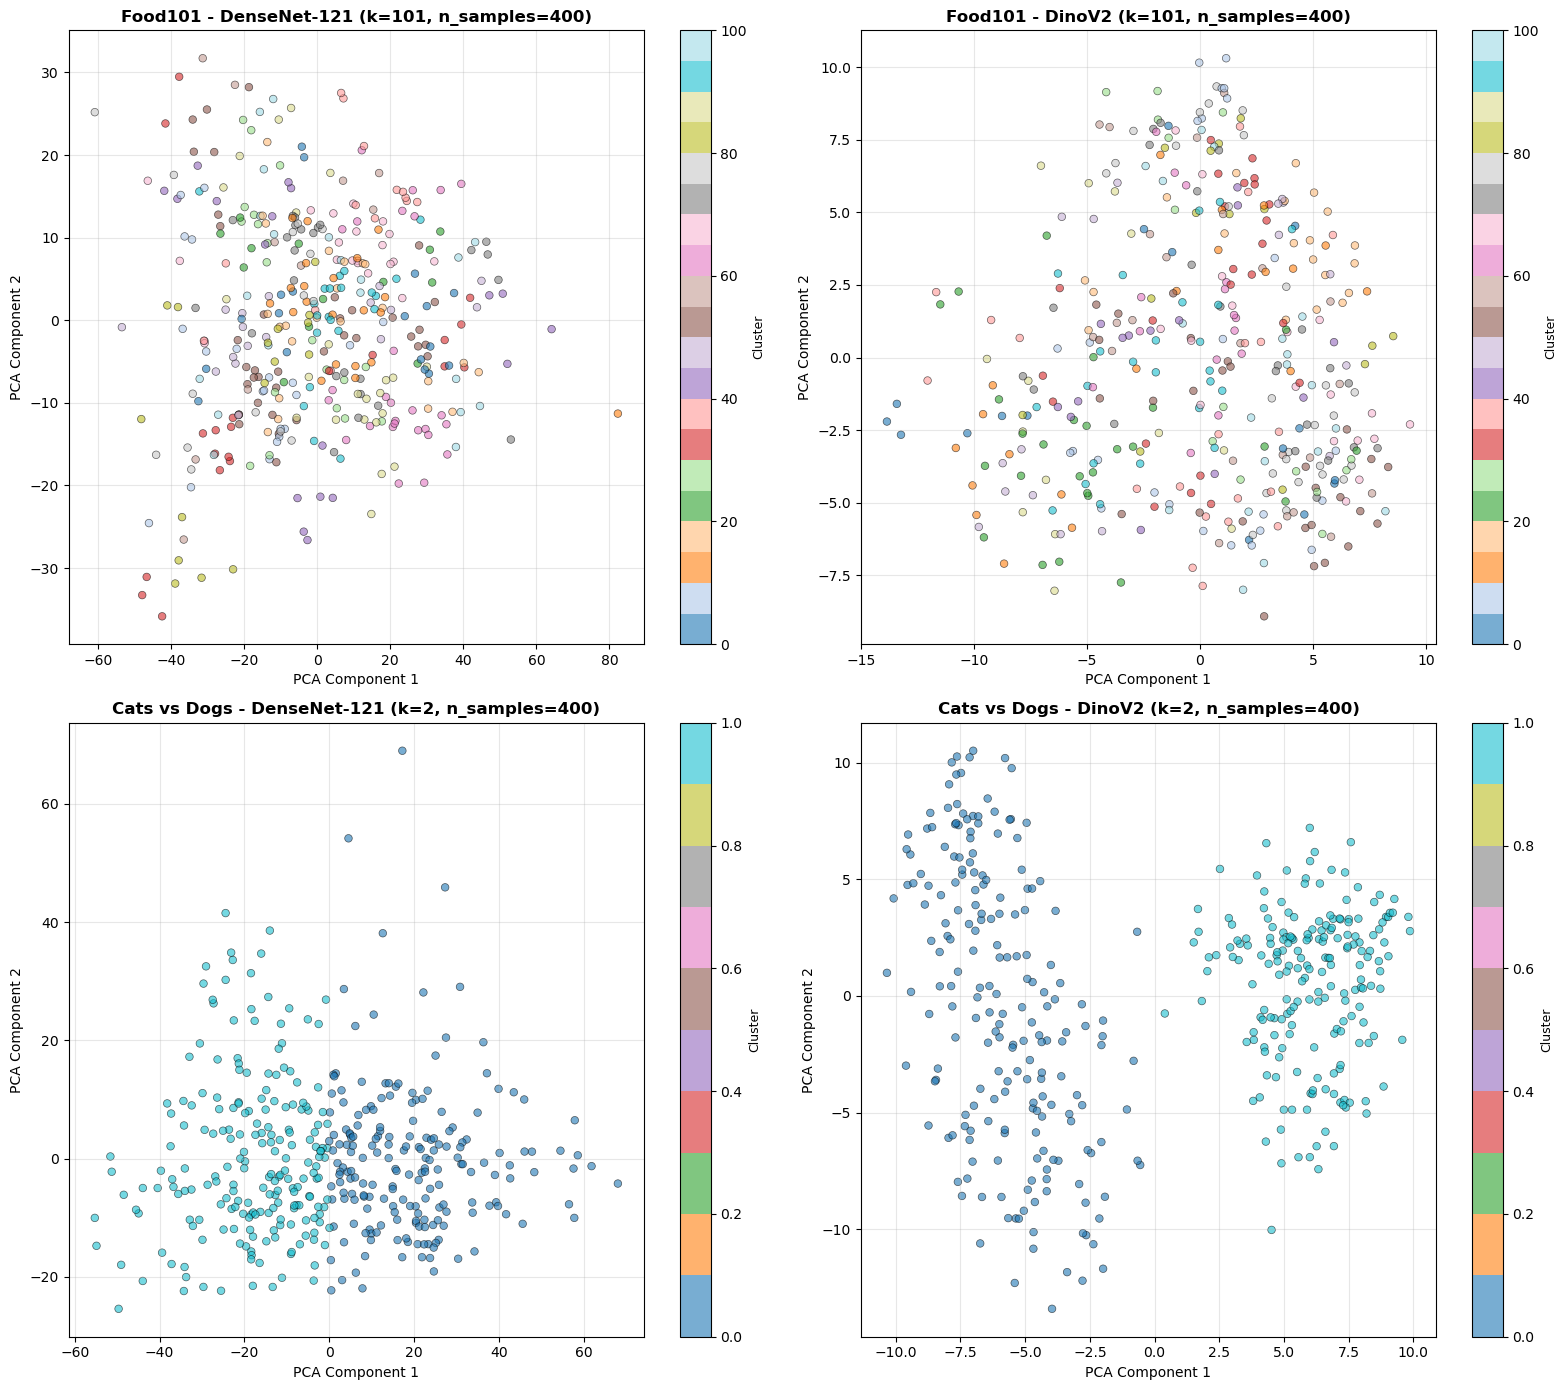


CLUSTERING RESULTS SUMMARY

Food101 - DenseNet-121 (k=101, n_samples=400):
  Silhouette Score: 0.0986
  Davies-Bouldin Index: 1.6199
  Calinski-Harabasz Score: 5728.69

Food101 - DinoV2 (k=101, n_samples=400):
  Silhouette Score: 0.0904
  Davies-Bouldin Index: 2.6753
  Calinski-Harabasz Score: 888.37

Cats vs Dogs - DenseNet-121 (k=2, n_samples=400):
  Silhouette Score: 0.3468
  Davies-Bouldin Index: 1.0796
  Calinski-Harabasz Score: 18609.98

Cats vs Dogs - DinoV2 (k=2, n_samples=400):
  Silhouette Score: 0.0973
  Davies-Bouldin Index: 3.0443
  Calinski-Harabasz Score: 2671.85


In [53]:
datasets_info = [
    (f_densenet_reduced, 101, "Food101 - DenseNet-121"),
    (f_dinov2_reduced, 101, "Food101 - DinoV2"),
    (cd_densenet_reduced, 2, "Cats vs Dogs - DenseNet-121"),
    (cd_dinov2_reduced, 2, "Cats vs Dogs - DinoV2")
]

clustering_results, fig = cluster_and_visualize_grid(
    datasets_info, 
    n_samples_viz=400, 
    figsize=(16, 14)
)

fig.savefig('images/clustering_all_2x2_grid.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("CLUSTERING RESULTS SUMMARY")
print("="*70)
for title, result in clustering_results.items():
    scores = result['scores']
    print(f"\n{title}:")
    print(f"  Silhouette Score: {scores['silhouette']:.4f}")
    print(f"  Davies-Bouldin Index: {scores['db']:.4f}")
    print(f"  Calinski-Harabasz Score: {scores['ch']:.2f}")

# Classification

## Linear Layer

In [9]:
class LinearLayer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


In [10]:
def train_model(features, labels, num_classes, num_epochs=100, batch_size=128, learning_rate=1e-3):
    input_dim = features.shape[1]
    model = LinearLayer(input_dim=input_dim, num_classes=num_classes)
    model = model.to(device)

    # Convert numpy arrays to PyTorch tensors
    features_tensor = torch.FloatTensor(features).to(device)
    labels_tensor = torch.LongTensor(labels).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    n_samples = len(features)
    n_batches = (n_samples + batch_size - 1) // batch_size

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        indices = torch.randperm(n_samples)

        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, n_samples)
            batch_indices = indices[start_idx:end_idx]

            batch_features = features_tensor[batch_indices]
            batch_labels = labels_tensor[batch_indices]

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(batch_indices)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == batch_labels).item()

        epoch_loss = running_loss / n_samples
        epoch_acc = correct_predictions / n_samples

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
    elapsed_time = time.time() - start_time
    print(f'Training done in {elapsed_time:.4f} seconds')
    return model


In [11]:
def evaluate(model, features, labels, dataset_name=None, label_encoder=None, batch_size=128):
    model.eval()
    
    features_tensor = torch.FloatTensor(features).to(device)
    labels_tensor = torch.LongTensor(labels).to(device)
    
    n_samples = len(features)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    all_preds = []
    correct = 0

    average = 'binary' if len(labels) == 2 else 'weighted'
    
    with torch.no_grad():
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, n_samples)
            
            batch_features = features_tensor[start_idx:end_idx]
            batch_labels = labels_tensor[start_idx:end_idx]
            
            outputs = model(batch_features)
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.cpu().numpy())
            correct += torch.sum(preds == batch_labels).item()
    
    all_preds = np.concatenate(all_preds)
    accuracy = accuracy_score(labels, all_preds)
    precision = precision_score(labels, all_preds, average=average)
    f1 = f1_score(labels, all_preds, average=average)
    
    target_names = None
    if label_encoder is not None:
        target_names = label_encoder.classes_
    
    report = classification_report(labels, all_preds, target_names=target_names, zero_division=0)
    
    print(f"\n{'='*70}")
    print(f"{dataset_name}")
    print(f"{'='*70}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1: {f1:.4f}")
    
    print(f"\nClassification Report:")
    print(report)
    print(f"{'='*70}\n")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': labels,
        'classification_report': report
    }


In [15]:
def prepare_classification_data(features_reduced, labels, test_size=0.2):
    le = LabelEncoder()
    y_encoded = le.fit_transform(labels)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features_reduced, y_encoded, 
        test_size=test_size, 
        random_state=SEED,
        stratify=y_encoded
    )
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Number of classes: {len(le.classes_)}")
    
    return {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'label_encoder': le
    }

In [16]:
f_densenet_classification_data = prepare_classification_data(f_densenet_reduced, f_labels_array, 0.2)

Train set: 80800 samples
Test set: 20200 samples
Number of classes: 101


In [20]:
print("Training on Food101 - DenseNet features")
print("="*70)

data = f_densenet_classification_data
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
label_encoder = data['label_encoder']

model = train_model(
    features=X_train, 
    labels=y_train, 
    num_classes=2,
    num_epochs=200,
    batch_size=128,
    learning_rate=1e-3
)


test_results = evaluate(
    model=model,
    features=X_test,
    labels=y_test,
    dataset_name="Food101 DenseNet",
    label_encoder=label_encoder
)

Training on Food101 - DenseNet features
Epoch [1/200], Loss: 0.0096, Acc: 0.0163
Epoch [10/200], Loss: 0.0090, Acc: 0.0170
Epoch [20/200], Loss: 0.0089, Acc: 0.0171
Epoch [30/200], Loss: 0.0087, Acc: 0.0173
Epoch [40/200], Loss: 0.0084, Acc: 0.0176
Epoch [50/200], Loss: 0.0082, Acc: 0.0178
Epoch [60/200], Loss: 0.0083, Acc: 0.0176
Epoch [70/200], Loss: 0.0084, Acc: 0.0176
Epoch [80/200], Loss: 0.0084, Acc: 0.0176
Epoch [90/200], Loss: 0.0082, Acc: 0.0178
Epoch [100/200], Loss: 0.0081, Acc: 0.0180
Epoch [110/200], Loss: 0.0080, Acc: 0.0180
Epoch [120/200], Loss: 0.0082, Acc: 0.0178
Epoch [130/200], Loss: 0.0082, Acc: 0.0178
Epoch [140/200], Loss: 0.0083, Acc: 0.0177
Epoch [150/200], Loss: 0.0082, Acc: 0.0178
Epoch [160/200], Loss: 0.0082, Acc: 0.0178
Epoch [170/200], Loss: 0.0082, Acc: 0.0178
Epoch [180/200], Loss: 0.0081, Acc: 0.0179
Epoch [190/200], Loss: 0.0080, Acc: 0.0180
Epoch [200/200], Loss: 0.0080, Acc: 0.0180
Training done in 200.3553 seconds

Food101 DenseNet
Accuracy: 0.0170

/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [17]:
f_dinov2_classification_data = prepare_classification_data(f_dinov2_reduced, f_labels_array, 0.2)

Train set: 80800 samples
Test set: 20200 samples
Number of classes: 101


In [22]:
print("Training on Food101 - DINOV2 features")
print("="*70)

data = f_dinov2_classification_data
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
label_encoder = data['label_encoder']

model = train_model(
    features=X_train, 
    labels=y_train, 
    num_classes=2,
    num_epochs=200,
    batch_size=128,
    learning_rate=1e-3
)


test_results = evaluate(
    model=model,
    features=X_test,
    labels=y_test,
    dataset_name="Food101 DINOV2",
    label_encoder=label_encoder
)

Training on Food101 - DINOV2 features
Epoch [1/200], Loss: 0.0065, Acc: 0.0196
Epoch [10/200], Loss: 0.0062, Acc: 0.0198
Epoch [20/200], Loss: 0.0062, Acc: 0.0198
Epoch [30/200], Loss: 0.0062, Acc: 0.0198
Epoch [40/200], Loss: 0.0062, Acc: 0.0198
Epoch [50/200], Loss: 0.0062, Acc: 0.0198
Epoch [60/200], Loss: 0.0062, Acc: 0.0198
Epoch [70/200], Loss: 0.0062, Acc: 0.0198
Epoch [80/200], Loss: 0.0062, Acc: 0.0198
Epoch [90/200], Loss: 0.0062, Acc: 0.0198
Epoch [100/200], Loss: 0.0062, Acc: 0.0198
Epoch [110/200], Loss: 0.0062, Acc: 0.0198
Epoch [120/200], Loss: 0.0062, Acc: 0.0198
Epoch [130/200], Loss: 0.0062, Acc: 0.0198
Epoch [140/200], Loss: 0.0062, Acc: 0.0198
Epoch [150/200], Loss: 0.0062, Acc: 0.0198
Epoch [160/200], Loss: 0.0062, Acc: 0.0198
Epoch [170/200], Loss: 0.0062, Acc: 0.0198
Epoch [180/200], Loss: 0.0062, Acc: 0.0198
Epoch [190/200], Loss: 0.0062, Acc: 0.0198
Epoch [200/200], Loss: 0.0062, Acc: 0.0198
Training done in 189.5444 seconds

Food101 DINOV2
Accuracy: 0.0197
Pre

/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [23]:
cd_densenet_classification_data = prepare_classification_data(cd_densenet_reduced, cd_labels_array, 0.2)

Train set: 19967 samples
Test set: 4992 samples
Number of classes: 2


In [24]:
print("Training on Cats vs Dogs - DenseNet features")
print("="*70)

data = cd_densenet_classification_data
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
label_encoder = data['label_encoder']

model = train_model(
    features=X_train, 
    labels=y_train, 
    num_classes=2,
    num_epochs=200,
    batch_size=128,
    learning_rate=1e-3
)


test_results = evaluate(
    model=model,
    features=X_test,
    labels=y_test,
    dataset_name="Cats vs Dogs DenseNet",
    label_encoder=label_encoder
)


Training on Cats vs Dogs - DenseNet features
Epoch [1/200], Loss: 0.6535, Acc: 0.6218
Epoch [10/200], Loss: 0.6163, Acc: 0.6695
Epoch [20/200], Loss: 0.6020, Acc: 0.6903
Epoch [30/200], Loss: 0.5931, Acc: 0.7012
Epoch [40/200], Loss: 0.5829, Acc: 0.7141
Epoch [50/200], Loss: 0.5753, Acc: 0.7261
Epoch [60/200], Loss: 0.5655, Acc: 0.7367
Epoch [70/200], Loss: 0.5589, Acc: 0.7447
Epoch [80/200], Loss: 0.5494, Acc: 0.7559
Epoch [90/200], Loss: 0.5411, Acc: 0.7668
Epoch [100/200], Loss: 0.5348, Acc: 0.7729
Epoch [110/200], Loss: 0.5340, Acc: 0.7726
Epoch [120/200], Loss: 0.5228, Acc: 0.7874
Epoch [130/200], Loss: 0.5192, Acc: 0.7922
Epoch [140/200], Loss: 0.5137, Acc: 0.7993
Epoch [150/200], Loss: 0.5133, Acc: 0.7977
Epoch [160/200], Loss: 0.5022, Acc: 0.8122
Epoch [170/200], Loss: 0.4981, Acc: 0.8181
Epoch [180/200], Loss: 0.4964, Acc: 0.8185
Epoch [190/200], Loss: 0.4925, Acc: 0.8233
Epoch [200/200], Loss: 0.4893, Acc: 0.8259
Training done in 49.4280 seconds

Cats vs Dogs DenseNet
Accurac

In [25]:
cd_dinov2_classification_data = prepare_classification_data(cd_dinov2_reduced, cd_labels_array, 0.2)

Train set: 19967 samples
Test set: 4992 samples
Number of classes: 2


In [26]:
print("Training on Cats vs Dogs - DINOV2 features")
print("="*70)

data = cd_dinov2_classification_data
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
label_encoder = data['label_encoder']

model = train_model(
    features=X_train, 
    labels=y_train, 
    num_classes=2,
    num_epochs=200,
    batch_size=128,
    learning_rate=1e-3
)


test_results = evaluate(
    model=model,
    features=X_test,
    labels=y_test,
    dataset_name="Cats vs Dogs DINOV2",
    label_encoder=label_encoder
)

Training on Cats vs Dogs - DINOV2 features
Epoch [1/200], Loss: 0.3387, Acc: 0.9880
Epoch [10/200], Loss: 0.3138, Acc: 0.9994
Epoch [20/200], Loss: 0.3137, Acc: 0.9995
Epoch [30/200], Loss: 0.3137, Acc: 0.9995
Epoch [40/200], Loss: 0.3137, Acc: 0.9995
Epoch [50/200], Loss: 0.3137, Acc: 0.9995
Epoch [60/200], Loss: 0.3137, Acc: 0.9995
Epoch [70/200], Loss: 0.3137, Acc: 0.9995
Epoch [80/200], Loss: 0.3137, Acc: 0.9995
Epoch [90/200], Loss: 0.3137, Acc: 0.9995
Epoch [100/200], Loss: 0.3137, Acc: 0.9995
Epoch [110/200], Loss: 0.3137, Acc: 0.9995
Epoch [120/200], Loss: 0.3142, Acc: 0.9990
Epoch [130/200], Loss: 0.3140, Acc: 0.9992
Epoch [140/200], Loss: 0.3140, Acc: 0.9992
Epoch [150/200], Loss: 0.3138, Acc: 0.9994
Epoch [160/200], Loss: 0.3138, Acc: 0.9994
Epoch [170/200], Loss: 0.3138, Acc: 0.9994
Epoch [180/200], Loss: 0.3138, Acc: 0.9994
Epoch [190/200], Loss: 0.3138, Acc: 0.9994
Epoch [200/200], Loss: 0.3138, Acc: 0.9994
Training done in 47.4425 seconds

Cats vs Dogs DINOV2
Accuracy: 0

## SVM

In [2]:
def train_and_evaluate_svc(X_train, X_test, y_train, y_test, label_encoder, dataset_name, kernel='rbf', C=1.0):
    print(f"\nTraining SVC on {dataset_name}")
    print("="*70)
    print(f"Kernel: {kernel}, C: {C}")
    
    start_time = time.time()
    
    clf = svm.SVC(kernel=kernel, C=C, random_state=SEED)
    clf.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    average = 'binary' if len(np.unique(y_test)) == 2 else 'weighted'
    precision = precision_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    
    target_names = label_encoder.classes_ if label_encoder is not None else None
    report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
    
    print(f"\n{'='*70}")
    print(f"Test Results - {dataset_name}")
    print(f"{'='*70}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nClassification Report:")
    print(report)
    print(f"{'='*70}\n")
    
    return {
        'clf': clf,
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1,
        'training_time': training_time,
        'predictions': y_pred
    }

In [18]:
print("Training on Food101 - DenseNet features")
print("="*70)

data = f_densenet_classification_data
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
label_encoder = data['label_encoder']
train_and_evaluate_svc(X_train, X_test, y_train, y_test, label_encoder, "Food101 - DenseNet")

Training on Food101 - DenseNet features

Training SVC on Food101 - DenseNet
Kernel: rbf, C: 1.0
Training completed in 144.82 seconds

Test Results - Food101 - DenseNet
Accuracy: 0.1162
Precision: 0.1003
F1 Score: 0.0973

Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.02      0.01      0.01       200
         baby_back_ribs       0.10      0.20      0.13       200
                baklava       0.09      0.11      0.10       200
         beef_carpaccio       0.33      0.13      0.19       200
           beef_tartare       0.03      0.01      0.01       200
             beet_salad       0.10      0.09      0.10       200
               beignets       0.11      0.39      0.17       200
               bibimbap       0.12      0.33      0.18       200
          bread_pudding       0.00      0.00      0.00       200
      breakfast_burrito       0.10      0.03      0.05       200
             bruschetta       0.04      

{'clf': SVC(random_state=42),
 'accuracy': 0.11623762376237624,
 'precision': 0.10030765119461471,
 'f1': 0.09725461103476832,
 'training_time': 144.81908106803894,
 'predictions': array([97, 20, 12, ..., 27, 26, 71], shape=(20200,))}

In [19]:
print("Training on Food101 - DINOV2 features")
print("="*70)

data = f_dinov2_classification_data
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
label_encoder = data['label_encoder']

train_and_evaluate_svc(X_train, X_test, y_train, y_test, label_encoder, "Food101 - DINOV2")

Training on Food101 - DINOV2 features

Training SVC on Food101 - DINOV2
Kernel: rbf, C: 1.0
Training completed in 64.57 seconds

Test Results - Food101 - DINOV2
Accuracy: 0.8640
Precision: 0.8655
F1 Score: 0.8643

Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.75      0.80      0.77       200
         baby_back_ribs       0.86      0.83      0.85       200
                baklava       0.92      0.89      0.90       200
         beef_carpaccio       0.88      0.84      0.86       200
           beef_tartare       0.79      0.79      0.79       200
             beet_salad       0.74      0.79      0.76       200
               beignets       0.86      0.93      0.89       200
               bibimbap       0.93      0.94      0.93       200
          bread_pudding       0.79      0.80      0.79       200
      breakfast_burrito       0.80      0.88      0.84       200
             bruschetta       0.84      0.79   

{'clf': SVC(random_state=42),
 'accuracy': 0.864009900990099,
 'precision': 0.8654669922168279,
 'f1': 0.8642757236315926,
 'training_time': 64.57002377510071,
 'predictions': array([42, 66, 12, ..., 47, 23, 18], shape=(20200,))}